<a href="https://colab.research.google.com/github/ionas-emanuela/Text-to-image-synthesis/blob/master/Text_to_Image_Synthesis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install torch===1.2.0 torchvision===0.4.0 -f https://download.pytorch.org/whl/torch_stable.html
!pip3 install torchvision
!pip install tensorboardX

In [0]:
!pip install image

In [0]:
!pip install utils

All the necessary imports are here

In [0]:
import tensorflow as tf

In [0]:
import torch
import torchvision
from torch import nn, optim
from torch.autograd.variable import Variable
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
import os
import numpy as np
import pandas as pd
import errno
import torchvision.utils as vutils
from tensorboardX import SummaryWriter
from IPython import display
import PIL.Image as Image
from matplotlib import pyplot as plt
import utils

import random

from numpy import expand_dims
from numpy import zeros
from numpy import ones
from numpy import asarray
from numpy.random import randn
from numpy.random import randint
from keras.datasets.fashion_mnist import load_data
from keras.optimizers import Adam
from keras.models import Model
from keras.models import load_model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Dropout
from keras.layers import Embedding
from keras.layers import Concatenate
from matplotlib import pyplot

Install the necessary libraries for connecting to google drive.


In [0]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [0]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

The attributes are taken from here [list_attr_celeba.txt](https://drive.google.com/open?id=0B7EVK8r0v71pblRyaVFSWGxPY0U).
They are presented as a table of 41 x 202599. The columns are the image_id + attributes and each row has a value of 1 or -1 (if the attribute is found or not in the image).

---

The attributes are the following (in this exact order) : ['image_id', '5_o_Clock_Shadow', 'Arched_Eyebrows', 'Attractive', 'Bags_Under_Eyes', 'Bald', 'Bangs', 'Big_Lips', 'Big_Nose', 'Black_Hair', 'Blond_Hair', 'Blurry', 'Brown_Hair', 'Bushy_Eyebrows', 'Chubby', 'Double_Chin', 'Eyeglasses', 'Goatee', 'Gray_Hair', 'Heavy_Makeup', 'High_Cheekbones', 'Male', 'Mouth_Slightly_Open','Mustache', 'Narrow_Eyes', 'No_Beard', 'Oval_Face', 'Pale_Skin', 'Pointy_Nose', 'Receding_Hairline', 'Rosy_Cheeks', 'Sideburns', 'Smiling', 'Straight_Hair', 'Wavy_Hair', 'Wearing_Earrings', 'Wearing_Hat', 'Wearing_Lipstick', 'Wearing_Necklace', 'Wearing_Necktie', 'Young']

---

Note that these values are saved in a DataFrame, so the indexing is done using .loc['image_id'], this will retrieve the row of data corresponding to a certain image.

---
The one-hot encoding vector obtained from the textual input is stored in a DataFrame of 40 x 1, the only occupied row being row 0.


In [0]:
def get_annotation():
  downloaded = drive.CreateFile({'id':'0B7EVK8r0v71pblRyaVFSWGxPY0U'})
  downloaded.GetContentFile('list_attr_celeba.txt')
  rfile = open('list_attr_celeba.txt', 'r')
  texts = rfile.read().split("\n")
  rfile.close()

  columns = np.array(texts[1].split(" "))
  columns = columns[columns != ""]
  df = []
  for txt in texts[2:]:
      txt = np.array(txt.split(" "))
      txt = txt[txt!= ""]
      df.append(txt)
        
  df = pd.DataFrame(df)
  ui = pd.DataFrame(columns = columns)

  if df.shape[1] == len(columns) + 1:
     columns = ["image_id"]+ list(columns)
  df.columns = columns  
  df = df.dropna()

  ## cast to integer
  for nm in df.columns:
      if nm != "image_id":
          df[nm] = pd.to_numeric(df[nm],downcast="integer")
  return(df, ui)

attributes, user_input = get_annotation()
#print(attributes)
#print(attributes['image_id'][0])

The images are taken from the website presented below. The data is stored in a list of size 202599. 


In [0]:
!mkdir data_faces && wget https://s3-us-west-1.amazonaws.com/udacity-dlnfd/datasets/celeba.zip 

In [0]:
import zipfile

with zipfile.ZipFile("celeba.zip","r") as zip_ref:
  zip_ref.extractall("data_faces/")

root = 'data_faces/img_align_celeba'
img_list = os.listdir(root)


The images are then cropped and resized to 64x64

In [0]:
crop_size = 108
re_size = 64
offset_height = (238 - crop_size) // 2  #floor division
offset_width = (178 - crop_size) // 2
crop = lambda x: x[:, offset_height:offset_height + crop_size, offset_width:offset_width + crop_size]

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Lambda(crop),
     transforms.ToPILImage(),
     transforms.Resize((re_size, re_size), interpolation=Image.BICUBIC),
     transforms.ToTensor(),
     transforms.Normalize(mean = [0.5]*3, std = [0.5]*3)
     ])

batch_size = 10
celeba_data = datasets.ImageFolder('./data_faces', transform=transform)
data_loader = DataLoader(celeba_data, batch_size = batch_size, shuffle = False)

path, ceva = celeba_data.imgs[1]

In [0]:
batch_it = iter(data_loader)

database_size = 1000

#batch, _ = next(batch_it)
#show(next(batch_it), renorm = True, nrow = 4)
#batch, _ = next(batch_it)
#show(batch[0:3], renorm = True, nrow = 4)

A class that holds all data regarding images (image, attributes and label). These are stored in three dictionaries: one for label-attributes, one for label-image and one for index-label. The index is needed in order to ensure that the values are correctly selected during the training process.

In [0]:
class ImageDictionary():
  def __init__(self):
    self.attributes = dict()
    self.images = dict()
    self.labels = dict()
  
  def addAttributes(self, key, attribute):
    self.attributes[key] = attribute

  def addImage(self, key, image):
    #print('whyyy but with image ')
    #print(image)
    #print(key)
    self.images[key] = image

  def addLabel(self, key, label):
    self.labels[key] = label

  def getAttributes(self, key):
    return self.attributes[key]

  def getImage(self, key):
    return self.images[key]

  def getLabel(self, key):
    return self.labels[key]

  def printLabelDictionary(self):
    print("index - label")
    for x, y in self.labels.items():
      print(x, y)


A method for initializing the dictionary that will hold all attributes.
This has to be done before the images are added since the attributes are taken from the database one time (first thing when the program is run). The images will be added later, in batches.

In [0]:
dictionary = ImageDictionary()

for i in range(0, database_size):
  attributes_list = [1]*40
  label = attributes['image_id'][i]
  #print(label)
  attributes_list[0] = attributes['5_o_Clock_Shadow'][i]
  attributes_list[1] = attributes['Arched_Eyebrows'][i]
  attributes_list[2] = attributes['Attractive'][i]
  attributes_list[3] = attributes['Bags_Under_Eyes'][i]
  attributes_list[4] = attributes['Bald'][i]
  attributes_list[5] = attributes['Bangs'][i]
  attributes_list[6] = attributes['Big_Lips'][i]
  attributes_list[7] = attributes['Big_Nose'][i]
  attributes_list[8] = attributes['Black_Hair'][i]
  attributes_list[9] = attributes['Blond_Hair'][i]
  attributes_list[10] = attributes['Blurry'][i]
  attributes_list[11] = attributes['Brown_Hair'][i]
  attributes_list[12] = attributes['Bushy_Eyebrows'][i]
  attributes_list[13] = attributes['Chubby'][i]
  attributes_list[14] = attributes['Double_Chin'][i]
  attributes_list[15] = attributes['Eyeglasses'][i]
  attributes_list[16] = attributes['Goatee'][i]
  attributes_list[17] = attributes['Gray_Hair'][i]
  attributes_list[18] = attributes['Heavy_Makeup'][i]
  attributes_list[19] = attributes['High_Cheekbones'][i]
  attributes_list[20] = attributes['Male'][i]
  attributes_list[21] = attributes['Mouth_Slightly_Open'][i]
  attributes_list[22] = attributes['Mustache'][i]
  attributes_list[23] = attributes['Narrow_Eyes'][i]
  attributes_list[24] = attributes['No_Beard'][i]
  attributes_list[25] = attributes['Oval_Face'][i]
  attributes_list[26] = attributes['Pale_Skin'][i]
  attributes_list[27] = attributes['Pointy_Nose'][i]
  attributes_list[28] = attributes['Receding_Hairline'][i]
  attributes_list[29] = attributes['Rosy_Cheeks'][i]
  attributes_list[30] = attributes['Sideburns'][i]
  attributes_list[31] = attributes['Smiling'][i]
  attributes_list[32] = attributes['Straight_Hair'][i]
  attributes_list[33] = attributes['Wavy_Hair'][i]
  attributes_list[34] = attributes['Wearing_Earrings'][i]
  attributes_list[35] = attributes['Wearing_Hat'][i]
  attributes_list[36] = attributes['Wearing_Lipstick'][i]
  attributes_list[37] = attributes['Wearing_Necklace'][i]
  attributes_list[38] = attributes['Wearing_Necktie'][i]
  attributes_list[39] = attributes['Young'][i]
  dictionary.addAttributes(label, attributes_list)


This code adds the images to the dictionary.
The images are added in batches of 10, hence the index formula **10*iteration + i** , where iteration is the training iteration (the index of the current batch in the original dataset).

In [0]:
def initialize_data(data, iteration):
  for i in range(0, len(data)):
    path, _ = celeba_data.imgs[10*iteration + i]
    label = path[-10:]
    dictionary.addImage(label, data[i])
    dictionary.addLabel(10*iteration + i, label)
    #print('initialize_data label ' + label)
    #show(batch[i], renorm = True, nrow = 4)
  #image_data = ImageData(image_dictionary, attributes)
  #list_attr = image_data.get_corresponding_attributes('000001.jpg')
  #print(list_attr.loc[0])
  #return image_dictionary

The Discriminator is based on the structure in the image:
![alt text](https://i.stack.imgur.com/JH24l.png)

 and this article on [cGANs](https://machinelearningmastery.com/how-to-develop-a-conditional-generative-adversarial-network-from-scratch/)

![Discriminator](https://3qeqpr26caki16dnhd19sv6by6v-wpengine.netdna-ssl.com/wp-content/uploads/2019/05/Plot-of-the-Discriminator-Model-in-the-Conditional-Generative-Adversarial-Network-664x1024.png)


nn.Conv2d:
<br>


*   in_channel -> equal to the number of neurons in the previous layer. Initial value is the number of channels of the image (in this case, 3 - coloured image)
*   out_channel -> the number of important attributes we want to find
*   kernel_size -> size of filter
*   stride, padding ( (kernel_size - 1)/2 )


Relu -> activation function (the neuron is fired or not)





nn.BCELoss() -> Binary Cross Entropy (we need a sigmoid layer in the 
network) - output belongs to [0,1]
<br>
Cross-entropy quantifies the difference between two probability distributions.
<br>
nn.MSELoss() -> Mean Squared Error (input and output have to have the same size and be float)
<br>
nn.L1Loss() -> Mean Absolute Error (input and output have to have the same size and be float)


Taken from [Pytorch basics - intro to dataloaders and loss functions](https://towardsdatascience.com/pytorch-basics-intro-to-dataloaders-and-loss-functions-868e86450047)

In [0]:
def create_discriminator(in_shape=(64,64,3), n_attributes=40):
  
  #input layer (from the image)
  in_attribute = Input(shape=(40,))

  #print("discriminator")
  #print(in_attribute.shape)

  #embedding
  in_attribute_embedding = Embedding(n_attributes, 67)(in_attribute)
  #dense - scale up to image dimensions (40,64*64*3)

  #print("discriminator")
  #print(in_attribute_embedding.shape)

  number_nodes = in_shape[0]*in_shape[1]
  in_attribute_embedding = Dense(number_nodes)(in_attribute_embedding)
  #print("discriminator")
  #print(in_attribute_embedding.shape)

  #reshape - (3,64,64)
  in_attribute_embedding = Reshape((in_shape[0], in_shape[1], 40))(in_attribute_embedding)

  #add the input image
  in_image = Input(shape=in_shape)
  
  #concatenation step -> will add a new channel to the image
  merged = Concatenate()([in_image, in_attribute_embedding])

  #print("discriminator")
  #print(merged.shape)

  #1st layer
  #conv2D -> downsample from (64,64,4) to (32,32,256)
  downsampled_image = Conv2D(128, (3,3), strides=(2,2), padding='same')(merged)
  downsampled_image = LeakyReLU(alpha=0.2)(downsampled_image)

  #print("layer 1")
  #print(downsampled_image.shape)

  #2nd layer
  #conv2D -> downsample from (32,32,256) to (16,16,256)
  downsampled_image = Conv2D(128, (3,3), strides=(2,2), padding='same')(downsampled_image)
  downsampled_image = LeakyReLU(alpha=0.2)(downsampled_image)

  #print("layer 2")
  #print(downsampled_image.shape)

  #3rd layer
  #conv2D -> downsample from (16,16,256) to (8,8,256)
  downsampled_image = Conv2D(128, (3,3), strides=(2,2), padding='same')(downsampled_image)
  downsampled_image = LeakyReLU(alpha=0.2)(downsampled_image)


  #print("layer 3")
  #print(downsampled_image.shape)

  #flatten to (8*8*128)
  flattened_image = Flatten()(downsampled_image)

  #print("flattened")
  #print(flattened_image.shape)

  #dropout -> no change -> remove unnecesarry nodes
  flattened_image = Dropout(0.4)(flattened_image)

  #dense -> output layer
  out_layer = Dense(1, activation='sigmoid')(flattened_image)

  #print("flattened")
  #print(out_layer.shape)

  #build the model -> add optimizer, loss function and metric
  model = Model([in_image, in_attribute], out_layer)

  #print("!!!!!!!!!!!!!")

  opt = Adam(lr=0.0002, beta_1=0.5)
  model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
  #print("?????????")
  return model

The Grenerator was inspired by the same paper as the Discriminator

![Generator](https://3qeqpr26caki16dnhd19sv6by6v-wpengine.netdna-ssl.com/wp-content/uploads/2019/05/Plot-of-the-Generator-Model-in-the-Conditional-Generative-Adversarial-Network-806x1024.png)

In [0]:
def create_generator(latent_dimension, n_attributes=40):
  #input layer (from the image)
  in_attribute = Input(shape=(40,))
  #embedding
  in_attribute_embedded = Embedding(n_attributes, 67)(in_attribute)
  
  #linear_multiplication
  number_nodes = 8*8
  in_attribute_embedded = Dense(number_nodes)(in_attribute_embedded)

  #print(in_attribute_embedded.shape)

  #reshape to (8,8,3)
  in_attribute_embedded = Reshape((8,8,40))(in_attribute_embedded)

  #print(in_attribute_embedded.shape)

  #generator input
  in_lat = Input(shape=(latent_dimension,))

  #print(in_lat.shape)

  #8x8 image
  number_nodes = 8*8*128
  gen = Dense(number_nodes)(in_lat)
  gen = LeakyReLU(alpha=0.2)(gen)
  gen = Reshape((8,8,128))(gen)

  #print(in_attribute_embedded.shape)
  #print(gen.shape)

  #merge image gen and input attribute
  merge = Concatenate()([gen, in_attribute_embedded])

  #print("merge")
  #print(merge.shape)

  #upsample to (16,16)
  gen = Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')(merge)
  gen = LeakyReLU(alpha=0.2)(gen)

  #upsample to (32,32)
  gen = Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')(gen)
  gen = LeakyReLU(alpha=0.2)(gen)
 
  #upsample to (64,64)
  gen = Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')(gen)
  gen = LeakyReLU(alpha=0.2)(gen)
 
  #output layer
  out_layer = Conv2D(3, (8,8), activation='tanh', padding='same')(gen)
 
  #model
  model = Model([in_lat, in_attribute], out_layer)
  return model



In [0]:
def create_gan(generator_model, discriminator_model):
  discriminator_model.trainable = False
  generator_noise, generator_attributes = generator_model.input
  generator_output = generator_model.output

  #print("gan")
  #print(generator_output.shape)

  gan_output = discriminator_model([generator_output, generator_attributes])

  model = Model([generator_noise, generator_attributes], gan_output)

  opt = Adam(lr=0.0002, beta_1=0.5)
  model.compile(loss='binary_crossentropy', optimizer=opt)
  return model

In [0]:
def load_real_data():
  
  for i in range(0, int(database_size/10)):
    batch, _ = next(batch_it)
    initialize_data(batch, i)


In [0]:
def generate_real_samples(db_size, number_samples):
  images = []
  attributes_list = []
  
  for i in range(0, number_samples):
    label = dictionary.getLabel(random.randint(0, db_size - 1))
    images.append(dictionary.getImage(label))
    attributes_list.append(dictionary.getAttributes(label))


  y = ones((number_samples, 1))

  return [images, attributes_list], y


generate points in latent space and reshape them into a batch of inputs for the network

In [0]:
def generate_random_attribute_list(number_samples):
  attributes_list = []
  for i in range(0, number_samples):
    attributes = []

    for j in range(0, 40):
      attributes.append(random.choice([-1,1]))

    attributes_list.append(attributes)
  
  return attributes_list

def generate_noise(latent_dim, number_samples, n_classes = 40):
  #print(latent_dim)
  x_input = randn(latent_dim * number_samples)
  z_input = x_input.reshape(number_samples, latent_dim)
  attributes = generate_random_attribute_list(number_samples)

  return [z_input, attributes]


In [0]:
def generate_fake_data(generator, latent_dim, number_samples):
  z_input, attribute_input = generate_noise(latent_dim, number_samples)
  #print("generate_fake_data")
  #print(z_input.shape)
  #print(np.array(attribute_input).shape)
  images = generator.predict([np.array(z_input), np.array(attribute_input)])

  y = zeros((number_samples, 1))
  return [images, attribute_input], y

In [0]:
def train(generator_model, discriminator_model, gan_model, 
          latent_dim, number_epochs = 100, number_batch = 256):
  
  batches_per_epoch = int(database_size / number_batch)
  half_batch = int(number_batch / 2)

  for epoch in range(number_epochs):
    for batch_index in range(batches_per_epoch):

      #print("aici")

      #get real data
      [x_real, attributes_real], y_real = generate_real_samples(database_size, half_batch)

      #print("aici 2")

      x_real_tensors_swapped = [tf.transpose(x, [1, 2, 0]) for x in x_real]
      x_real_array = [x.numpy() for x in x_real_tensors_swapped]

      #print(x_real_array[0].shape)
      #print(np.array(attributes_real).shape)
      #print(np.array(y_real).shape)

      d_loss1, _ = discriminator_model.train_on_batch([x_real_array, attributes_real], y_real)

      #print("aici 3")
      #print(latent_dim)

      #get fake data
      [x_fake, attributes], y_fake = generate_fake_data(generator_model, latent_dim, half_batch)

      #print("aici 4")

      d_loss2, _ = discriminator_model.train_on_batch([np.array(x_fake), np.array(attributes)], np.array(y_fake))

      #get noise
      [z_input, attributes_input] = generate_noise(latent_dim, number_batch)

      y_gan = ones((number_batch, 1))

      g_loss = gan_model.train_on_batch([np.array(z_input), np.array(attributes_input)], np.array(y_gan))

      #summarise loss on this batch
      print('> epoch: %d, (batch_index/batches_per_epoch): %d/%d, d1=%.3f, d2=%.3f g=%.3f' % 
            (epoch + 1, batch_index, batches_per_epoch, d_loss1, d_loss2, g_loss))
  generator_model.save('cgan_generator.h5')


In [28]:
latent_dim = 100

discriminator_model = create_discriminator()
generator_model = create_generator(latent_dim)
gan_model = create_gan(generator_model, discriminator_model)

dataset = load_real_data()

train(generator_model, discriminator_model, gan_model, latent_dim)

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


> epoch: 1, (batch_index/batches_per_epoch): 0/3, d1=0.731, d2=0.696 g=0.693
> epoch: 1, (batch_index/batches_per_epoch): 1/3, d1=0.617, d2=0.697 g=0.692
> epoch: 1, (batch_index/batches_per_epoch): 2/3, d1=0.522, d2=0.700 g=0.689
> epoch: 2, (batch_index/batches_per_epoch): 0/3, d1=0.430, d2=0.709 g=0.681
> epoch: 2, (batch_index/batches_per_epoch): 1/3, d1=0.326, d2=0.731 g=0.663
> epoch: 2, (batch_index/batches_per_epoch): 2/3, d1=0.220, d2=0.777 g=0.634
> epoch: 3, (batch_index/batches_per_epoch): 0/3, d1=0.168, d2=0.847 g=0.608
> epoch: 3, (batch_index/batches_per_epoch): 1/3, d1=0.143, d2=0.900 g=0.607
> epoch: 3, (batch_index/batches_per_epoch): 2/3, d1=0.143, d2=0.878 g=0.661
> epoch: 4, (batch_index/batches_per_epoch): 0/3, d1=0.140, d2=0.764 g=0.785
> epoch: 4, (batch_index/batches_per_epoch): 1/3, d1=0.146, d2=0.624 g=0.981
> epoch: 4, (batch_index/batches_per_epoch): 2/3, d1=0.127, d2=0.498 g=1.179
> epoch: 5, (batch_index/batches_per_epoch): 0/3, d1=0.137, d2=0.454 g=1.236

In [0]:
def display_image_result(results, n):
  for i in range(n*n):
    pyplot.subplot(n, n, 1+i)
    pyplot.axis('off')
    pyplot.imshow(results[i,:,:,0])
  pyplot.show()

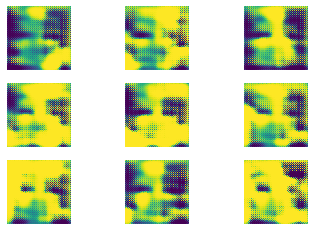

In [37]:
model = generator_model

noise, _ = generate_noise(100,100)
attributes = []

for i in range(0,100):
  attributes.append([-1,1,-1,-1,-1,1,1,1,1,-1,1,-1,1,-1,1,-1,-1,1,1,-1, -1,1,1,1,1,1,1,1,-1,-1,-1,1,1,-1,-1,-1,-1,-1,-1,-1])

X = model.predict([np.array(noise), np.array(attributes)])
X = (X+1)/2.0
display_image_result(X,3)

In [0]:
torch.cuda.is_available()